In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [91]:
df = pd.read_csv("adult.csv")
df.columns = df.columns.str.replace("." , "_" )
df

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


In [ ]:
# Replace missing values ("?") in workclass and occupation with "Unknown"
df['workclass'] = df['workclass'].replace('?', 'Unknown')
df["occupation"] = df["occupation"].replace('?', 'Unknown') 

df = df.loc[~df["workclass"].isin(["Never-worked", "Without-pay"])] 
# Drop rows where workclass is "Never-worked" or "Without-pay"
# because these categories are very rare and don't provide useful
# information for predicting income.


df["workclass"] = df["workclass"].replace({
    "Local-gov":"Goverment",
    "State-gov" : "Goverment", # Merge all types of government work into a single category "Government"
    "Federal-gov" : "Goverment"
})

df.drop(columns="fnlwgt" , inplace=True) # Drop fnlwgt (sampling weight), as it is not a predictive feature

df.loc[(df['education_num'] <= 8) | (df['education_num'] == 'Preschool'), 'education_num'] = 8
df.drop(columns="education" , inplace=True)
# Group all low education levels (<=8 years or Preschool) into one category "8"
# This simplifies the feature and avoids too many sparse categories


# Merge rare marital status categories:
# - "Married-AF-spouse" into "Married-civ-spouse"
# - "Married-spouse-absent" into "Separated"
df["marital_status"] = df["marital_status"].replace({
    "Married-AF-spouse" : "Married-civ-spouse",
    "Married-spouse-absent":"Separated", # add these feature to one groups
})

# Merge rare occupations to simplify categories:
# - Combine "Protective-serv" and "Armed-Forces" into "Protective/Armed"
# - Combine "Handlers-cleaners" and "Priv-house-serv" into "Other-service"
df["occupation"] = df["occupation"].replace({
    "Protective-serv":"Protective/Armed",
    "Armed-Forces" : "Protective/Armed",
    "Handlers-cleaners" : "Other-service",
    "Priv-house-serv":"Other-service"
})

# Simplify relationship: group "Not-in-family" and "Own-child" into "Single"

df["relationship"] = df["relationship"].replace({
    "Not-in-family" : "Single",
    "Own-child" : "Single"
})
# Group "Amer-Indian-Eskimo" into "Other" to reduce sparsity

df["race"] = df["race"].replace("Amer-Indian-Eskimo" ,"Other")

# Drop native_country since >90% of values are "United-States"
# It does not add much predictive power and may cause model bias
df.drop(columns="native_country" , inplace=True)

# Convert sex to numeric (Male=1, Female=0)
df["sex"] = df["sex"].replace({
    "Male":1,
    "Female":0
})

C:\Users\Arya\AppData\Local\Temp\ipykernel_8756\2103034022.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["workclass"] = df["workclass"].replace({
C:\Users\Arya\AppData\Local\Temp\ipykernel_8756\2103034022.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns="fnlwgt" , inplace=True)
C:\Users\Arya\AppData\Local\Temp\ipykernel_8756\2103034022.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

In [93]:
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
"""
Create a stratified train-test split 
(preserves target class distribution)
n_splits=10 -> generate 10 different splits (but we will just use the first one)
test_size=0.2 -> 20% of the data will be in the test set
"""
sss = StratifiedShuffleSplit(n_splits=10 , random_state=42 , test_size=0.2)
Stratifiedlist = []
for train_index , test_index in sss.split(df , df["income"]):
    sratified_train = df.iloc[train_index]
    sratified_test = df.iloc[test_index]

    Stratifiedlist.append([sratified_train ,sratified_test ])

train , test = Stratifiedlist[0]

In [ ]:
X_train = train.drop(columns=["income"])
y_train = train["income"]
X_test = test.drop(columns=["income"])
y_test = test["income"]

In [ ]:
# Convert target column (income) to numeric for better model performance
# '>50K' becomes 1, '<=50K' becomes 0
y_train = y_train.apply(lambda x: 1 if x == '>50K' else 0)
y_test = y_test.apply(lambda x: 1 if x == '>50K' else 0)

In [102]:
from sklearn.preprocessing import OneHotEncoder , StandardScaler
from sklearn.compose import ColumnTransformer

In [103]:
numeric = ["age" , "education_num" , "capital_gain","capital_loss","hours_per_week"]
categorical = ["workclass" , "marital_status" , "occupation" ,"relationship" , "race"]

In [104]:
preprocessor = ColumnTransformer(transformers=[
    ("num" , StandardScaler() , numeric),
    ("cat" , OneHotEncoder() , categorical),
])

X_train_t= preprocessor.fit_transform(X_train).toarray()
X_test_t= preprocessor.transform(X_test).toarray()

X_train = pd.DataFrame(X_train_t, columns=preprocessor.get_feature_names_out(), index=X_train.index)
X_test = pd.DataFrame(X_test_t, columns=preprocessor.get_feature_names_out(), index=X_test.index)

In [134]:
from sklearn.metrics import f1_score , recall_score , precision_score , ConfusionMatrixDisplay , accuracy_score,confusion_matrix

In [107]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors=11)

In [109]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=11)

In [136]:
knn_pred = knn.predict(X_test)

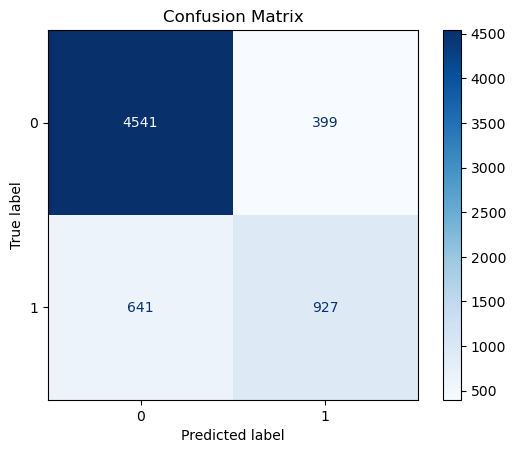

In [138]:
cm = confusion_matrix(y_test , knn_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [119]:
from sklearn.ensemble import RandomForestClassifier

In [120]:
rfr = RandomForestClassifier(n_estimators=500 , max_depth=15)

In [121]:
rfr.fit(X_train , y_train)

RandomForestClassifier(max_depth=15, n_estimators=500)

In [122]:
rfr_pred = rfr.predict(X_test)

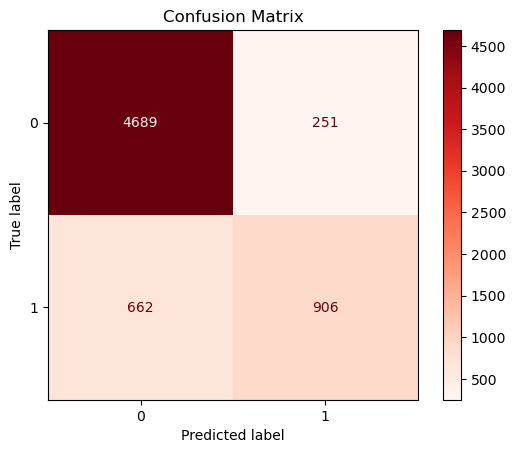

In [139]:
cm_rfr = confusion_matrix(y_test , rfr_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rfr)
disp.plot(cmap='Reds')
plt.title('Confusion Matrix')
plt.show()

In [124]:
from xgboost import XGBClassifier

In [125]:
xgb_model = XGBClassifier(
    n_estimators=2000,
    max_depth=8,
    gamma=2,
    subsample=0.7,
    learning_rate=0.01,          # کمک به کاهش overfitting
    colsample_bytree=0.85,        # هر درخت فقط از 80٪ ویژگی‌ها استفاده کنه → مدل generalize بهتر
    random_state=42,
    n_jobs=-1                    # استفاده از همه CPU ها
)

In [126]:
xgb_model.fit(
    X_train, y_train,
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.85, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=2000,
              n_jobs=-1, num_parallel_tree=None, ...)

In [127]:
xgb_pred = xgb_model.predict(X_test)

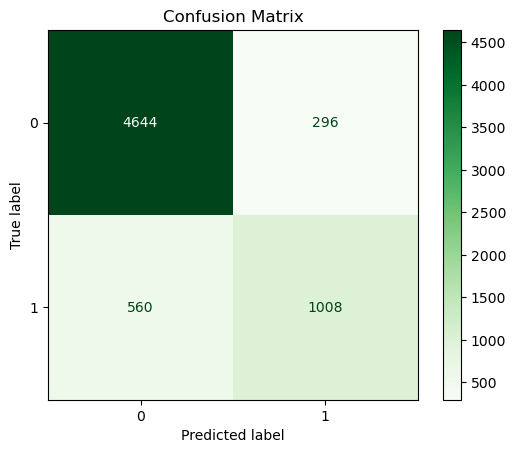

In [140]:
cm_xgb = confusion_matrix(y_test , xgb_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb)
disp.plot(cmap='Greens')
plt.title('Confusion Matrix')
plt.show()

In [143]:
from sklearn.svm import SVC

In [150]:
svc_model = SVC(kernel="rbf", class_weight="balanced")
svc_model.fit(X_train, y_train)

SVC(class_weight='balanced')

In [151]:
svc_pred = svc_model.predict(X_test)

In [152]:
f1_score(y_test , svc_pred)

0.6714727085478888

In [169]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(
    iterations=2000,
    depth=5,
    learning_rate=0.01,
    eval_metric='F1',
    verbose=100
)

cat_model.fit(X_train, y_train, eval_set=(X_test, y_test))
y_pred = cat_model.predict(X_test)

from sklearn.metrics import f1_score
print("F1 Score:", f1_score(y_test, y_pred))


0:	learn: 0.6461565	test: 0.6331939	best: 0.6331939 (0)	total: 55.6ms	remaining: 1m 51s
100:	learn: 0.6429106	test: 0.6213152	best: 0.6331939 (0)	total: 2.66s	remaining: 50.1s
200:	learn: 0.6496563	test: 0.6301473	best: 0.6331939 (0)	total: 4.85s	remaining: 43.4s
300:	learn: 0.6578799	test: 0.6370539	best: 0.6370539 (300)	total: 6.63s	remaining: 37.4s
400:	learn: 0.6698209	test: 0.6464646	best: 0.6472129 (388)	total: 8.61s	remaining: 34.3s
500:	learn: 0.6775292	test: 0.6546259	best: 0.6548673 (499)	total: 10.5s	remaining: 31.4s
600:	learn: 0.6843739	test: 0.6576346	best: 0.6578755 (590)	total: 12.7s	remaining: 29.6s
700:	learn: 0.6895176	test: 0.6615665	best: 0.6618076 (688)	total: 14.4s	remaining: 26.7s
800:	learn: 0.6929603	test: 0.6659420	best: 0.6659420 (797)	total: 16.1s	remaining: 24.1s
900:	learn: 0.6985663	test: 0.6702781	best: 0.6702781 (891)	total: 17.6s	remaining: 21.5s
1000:	learn: 0.7028953	test: 0.6733958	best: 0.6733958 (967)	total: 19.3s	remaining: 19.3s
1100:	learn: 0.

In [129]:
from sklearn.model_selection import GridSearchCV

In [130]:
param_grid = {"max_depth": [5,6,7,8,9,10],
              "n_estimators=2000":[1000,1500 , 1700 , 1900 , 2200],
              "gamma":[0,0.5,1,2],
              "subsample":[0.6 , 0.7,0,8,0,9],
              "colsample_bytree":[0.6 , 0.7,0,8,0,9]
              }

In [131]:
gs = GridSearchCV(XGBClassifier(), param_grid ,scoring="f1" , cv=5 )  

In [133]:
gs.fit(X_train[:5000] , y_train[:5000] )

e:\Anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [03:16:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "n_estimators=2000" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
e:\Anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [03:16:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "n_estimators=2000" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


KeyboardInterrupt: 

In [ ]:
gs.best_params_

{'colsample_bytree': 0.6,
 'gamma': 2,
 'max_depth': 5,
 'n_estimators=2000': 1000,
 'subsample': 0.7}